# Exercise 4 $\newcommand{\norm}[2][]{\Vert #2 \Vert_{#1}}$ $\newcommand{\R}{\mathbb{R}}$ $\newcommand{\spMat}{\mathbb{R}^{M\times N}}$ $\newcommand{\abs}[1]{\vert #1 \vert}$ $\newcommand{\linK}{\mathcal K}$ $\newcommand{\linI}{\mathcal I}$ $\newcommand{\shrinkage}[2][]{\mathcal S_{#1} (#2) }$$\DeclareMathOperator*{\argmin}{argmin}$ $ \newcommand{\prox}[2]{\mathrm{prox}_{#2}^{#1}} $ $ \newcommand{\scal}[2]{\left\langle #1,#2 \right\rangle}      % scalar product $

## Background Subtraction

In the background subtraction problem, we are given video data from, for example, a surveillance camera, i.e., a sequence of images taken from a fixed camera perspective. In such an environment, the static part of the video (the part that does not change over time) is considered as background. The goal of this task is to extract the moving objects in the video (the pixel data that changes). We can assume that large parts of the scene are composed of the background and therefore, the moving objects can be considered as outliers in the scene. The problem is modeled as follows:

We are given $N$ observations (frames in the video) of dimension $M$ (number of pixels in a image), which we collect as columns of a matrix $A\in \spMat$. Suppose the observations are linearly depended up to some gross outliers. We formulate an optimization problem that decomposes $A$ into a matrix $X$ that contains the outliers and a low-rank matrix $Y$ that extracts the part of the observations that lies on a low dimensional subspace, i.e., $A \approx X+Y$.

This goal is formulated as the following *convex Robust PCA* problem:
$$\min_{X, Y\in\spMat} f(X, Y)\,, \quad f(X, Y) := \frac{1}{2}\norm[F]{X+Y-A}^2 + \mu \norm[1]{X} + \rho\norm[*]{Y}\,,$$
where
$$\begin{split}
  \norm[1]{X}:=&\  \sum_{i=1}^M \sum_{j=1}^N \abs{X_{i,j}} \qquad \text{(1-norm)} \\
  \norm[F]{B}:=&\ \Big(\sum_{i=1}^M\sum_{j=1}^N \abs{B_{i,j}}^2 \Big)^{1/2}\qquad \text{(Frobenius norm)} \\
  \norm[*]{Y}:=&\ \sum_{i=1}^{\min(M,N)} \sigma_i \qquad \text{(nuclear norm)} \,.
\end{split}$$
where $\sigma_1,\ldots,\sigma_{\min(M,N)}$ are the singular values of $Y$, and $\rho,\mu>0$. You should convince yourself that $f(X,Y)$ is a convex function.

## Making the Objective Smooth

The objective $f$ in the above problem is non-smooth. In order to make it amenable for smooth optimization algorithms, we rely on a prominent smoothing technique in this context, known as the Moreau-envelope (or Moreau-Yosida regularization). *The theoretical background of the smoothing and some properties are provided in Appendix F of the lecture notes*. This is a smooth lower approximation of the function $f$ that is $L$-smooth with a parameter $L$ that corresponds to the smoothing parameter. One of the key features of the Moreau-envelope is that its gradient reveals a simple expression that can be computed efficiently (in some situations). Therefore, this smoothing technique is a perfect candidate for gradient based optimization algorithms. 

For the present task, the Moreau envelope with respect to a very specific choice of induced norm $\norm[\Omega]{X}=\scal{X}{\Omega X}_F $ (for a positive definite mapping $\Omega$) is required. We define the new objective $e_\lambda^\Omega f : \spMat\times\spMat\to\R $ (the Moreau envelope of $f$ with respect to $\norm[\Omega]{\cdot}$) for some $\lambda>0$ (smoothing parameter) by:
$$e_\lambda^\Omega f(\bar X, \bar Y) = \min_{X, Y} f(X, Y) + \frac{1}{2\lambda}\norm[\Omega]{(X, Y) - (\bar X, \bar Y)}^2$$

It can be shown that:
$$\argmin_{X, Y\in\spMat} e_\lambda^\Omega f(X, Y) = \argmin_{X, Y\in\spMat} f (X, Y)$$
In general, computing $e_\lambda^\Omega$ or $\nabla e_\lambda^\Omega$ may not be possible, but for special cases such as the above, we can still do it by choosing the Metric carefully. Let $\linI$ be the identity mapping on $\spMat\times\spMat$ and $\linK : \spMat\times\spMat \to \spMat$ be defined as $\linK(X, Y) := X + Y$, then for $\lambda = 1$ and $\Omega:=\frac{1}{\tau}\linI - \linK^*\linK$ it can be shown that (See Theorem F.7 in the appendix of the lecture notes):
$$\nabla e_\lambda^\Omega (\bar X, \bar Y) = (\bar X, \bar Y) - \prox \Omega f (\bar X, \bar Y) \,, $$
where $\tau>0$ is chosen such that $\Omega$ is positive definite and
$$ \prox \Omega f (\bar X, \bar Y) := \argmin_{X, Y} f(X, Y) + \frac{1}{2}\norm[\Omega]{(X, Y) - (\bar X, \bar Y)}^2 $$

#### Hint
For computing the gradient, try to express $ \prox \Omega f (\bar X, \bar Y) $ in a more convenient form, i.e.,
$$ \prox \Omega f (\bar X, \bar Y) = \big( \prox{}{\tau\mu\norm[1]{\cdot}}(g(\bar X, \bar Y)), \prox{}{\tau\rho\norm[*]{\cdot}}(h(\bar X, \bar Y)) \big)\,, $$
for some simple functions $ g, h : \spMat\times\spMat\to\spMat $.

#### Note
You will find the following fact useful in your computation of $ \nabla e_\lambda^\Omega $. Let $ U\Sigma V^T $ be the singular value decomposition of $ \bar Y $, then $ \prox{}{\norm[*]{\cdot}} (\bar Y) = U\shrinkage[\tau\rho]{\Sigma}V^T $ where
$$(\shrinkage[\lambda]{B})_{i, j} := \begin{cases}
  B_{i,j} - \lambda \,, &\ \text{if}\ B_{i,j} >\lambda \,; \\
  B_{i,j} + \lambda \,, &\ \text{if}\ B_{i,j} <-\lambda \,; \\
  0 \,, &\ \text{otherwise}
  \end{cases} $$
is the shrinkage function with parameter $\lambda > 0$. You will have to compute $ \hat X $ by yourself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
* A: data matrix of size (M, N)
* Each column of A is a vectorized image with size M (corresponding to size (nx, ny), i.e., M = nx * ny)

In [2]:
A, N, M, nx, ny = np.load('data.npy', allow_pickle=True);

### Auxilliary function
Given t, convert the $\mathrm{t}^{\mathrm{th}}$ column vector of A into an image of size (nx, ny).

In [3]:
def convert2image(A, t):
    return A[:, t].reshape(ny, nx)

### Shrinkage function:

#### Task 1 - Implement the shrinkage function $\shrinkage[\lambda] B$ below. (2 points)

In [4]:
def shrinkage(B, lam):
    U, S, Vh = np.linalg.svd(B, full_matrices=False)
    S_thresh = np.maximum(S - lam, 0)
    return U @ np.diag(S_thresh) @ Vh

### Objective Function

#### Task 2 - Implement the objective function $f$ below. (1 point)

In [5]:
def objective(X, Y):
    return np.linalg.norm(X - Y, 'fro')**2

### Gradient

#### Task 3 - Implement the gradient of the regularized objective $ \nabla f_\Omega $ below. (9 points)

In [6]:
def gradient(X_bar, Y_bar):
    grad_X = X_bar + Y_bar - A
    grad_Y = X_bar + Y_bar - A
    return grad_X, grad_Y

### Initializing the Parameters

In [7]:
# initialize 
###############################################################################
# TODO: 
# - find a suitable intialization for the unknowns $X$ and $Y$
# - compute the Lipschitz constant $L$ of the gradient of the smooth part of the objective 
# - set the step size parameter $tau$ such that the algorithm converges

###############################################################################
Xk = np.random.rand(M,N)
Yk = np.ones((M,N))
tau= 0.25
stepsize = 1

# Model parameters
# Select suitable parameters mu and rho of the optimization model 
mu =0.2
rho= 100

maxiter = 100;
check = 10;       # print the objective value and the rank of $Y$ after $check$ iterations
tol = 1e-6;       # break iterations if the residual $res$ drops below $tol$

### Implementing the Algorithm

The code for gradient descent is given below. You are required to update it to accelerated gradient descent.

#### Task 4 - Update the code below. (3 points)

In [8]:
for itr in np.arange(maxiter):
    # TODO: Update the code below
    grad_X, grad_Y = gradient(Xk, Yk)
    Xk = Xk - stepsize * grad_X
    Ykp1 = Yk - stepsize * grad_Y
    res = np.linalg.norm(Ykp1 - Yk, 'nuc')
    Yk = Ykp1
    if (itr+1) % check == 0:
        print("After", itr+1, "iterations,", end=" ")
        print("objective value =", objective(Xk, Yk), end=" ")
        print("and rank of Y =", np.linalg.matrix_rank(Yk))
    if res < tol:
        break

After 10 iterations, objective value = 640414.213695279 and rank of Y = 1
After 20 iterations, objective value = 640414.213695279 and rank of Y = 1
After 30 iterations, objective value = 640414.213695279 and rank of Y = 1
After 40 iterations, objective value = 640414.213695279 and rank of Y = 1
After 50 iterations, objective value = 640414.213695279 and rank of Y = 1
After 60 iterations, objective value = 640414.213695279 and rank of Y = 1
After 70 iterations, objective value = 640414.213695279 and rank of Y = 1
After 80 iterations, objective value = 640414.213695279 and rank of Y = 1
After 90 iterations, objective value = 640414.213695279 and rank of Y = 1
After 100 iterations, objective value = 640414.213695279 and rank of Y = 1


### Visualization

Visualize every 10th image in the dataset, its foreground and background.

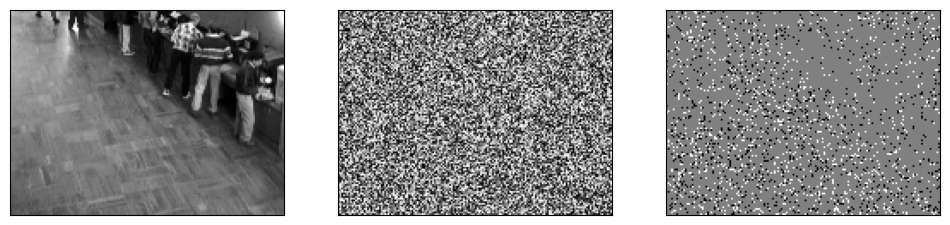

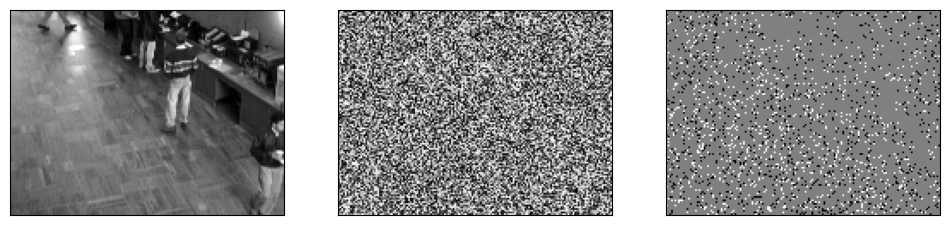

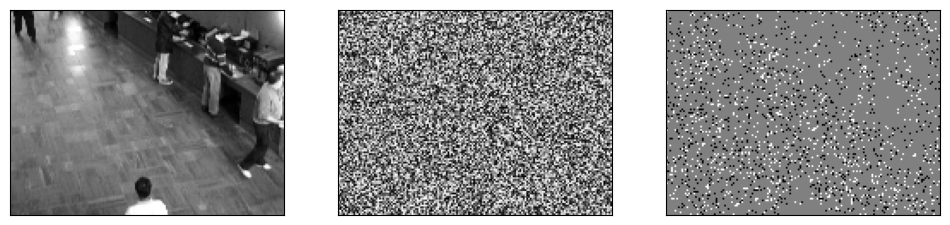

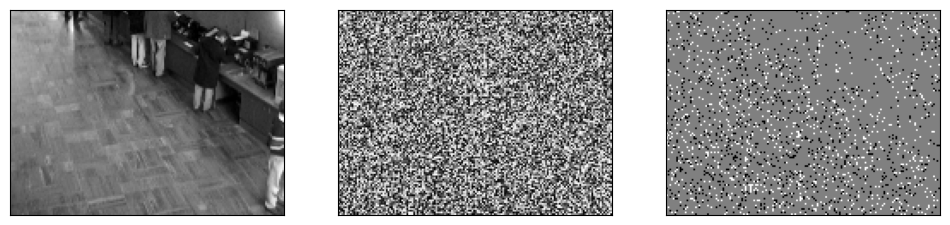

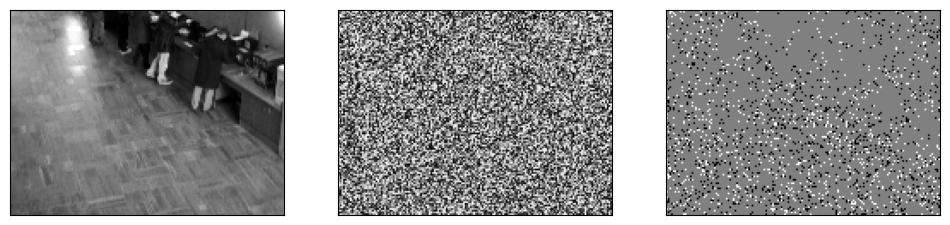

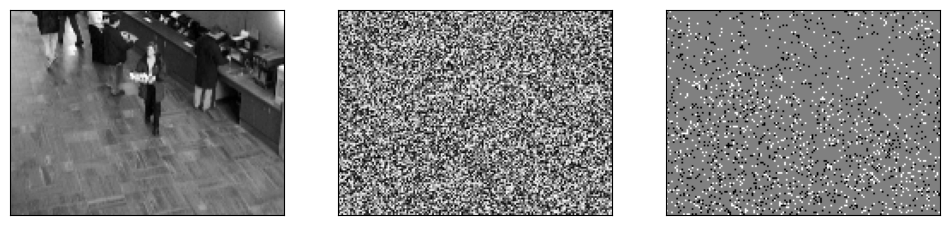

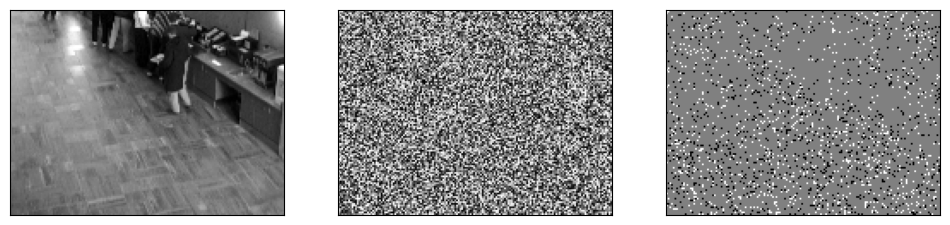

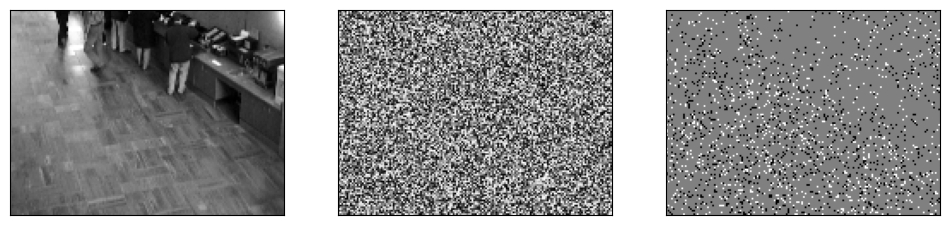

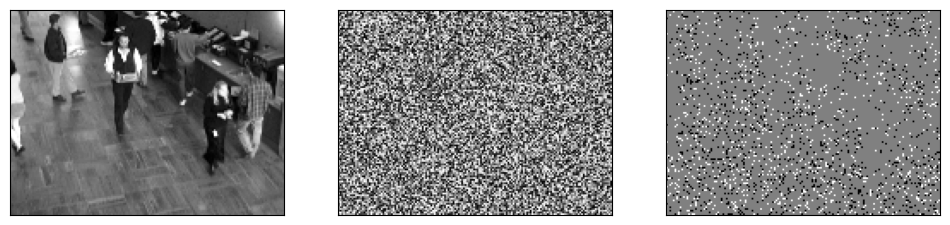

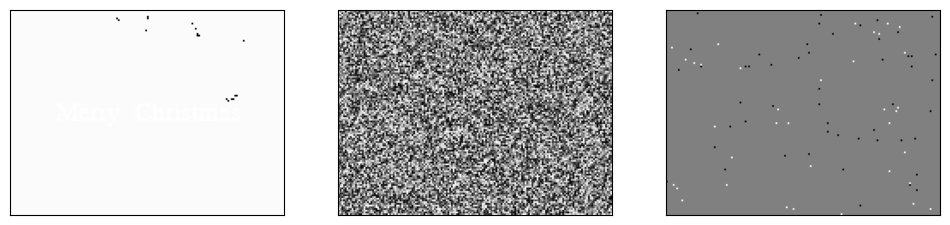

In [9]:
for i in np.arange(0, int(N/10)):
    ind = int(10*i) + 9
    img = np.stack((convert2image(A,ind), 
                    convert2image(Xk,ind), 
                    convert2image(Yk,ind)), axis=2)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for j in range(3):
        ax[j].imshow(img[:, :, j], cmap='gray')
        ax[j].set_xticks([])
        ax[j].set_yticks([])